Step 1: Import required libraries and models

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import joblib
import warnings
warnings.filterwarnings('ignore')

Step 2: Load the data and describe columns

In [2]:
# Load the data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df.head(5)
test_df.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


Step 3: Exploratory Data Analysis & Data Visualization

Train data shape: (8693, 14)
Test data shape: (4277, 13)
Train data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None
Test data info:
<class 'pandas.core.frame.DataFrame'>
RangeInde

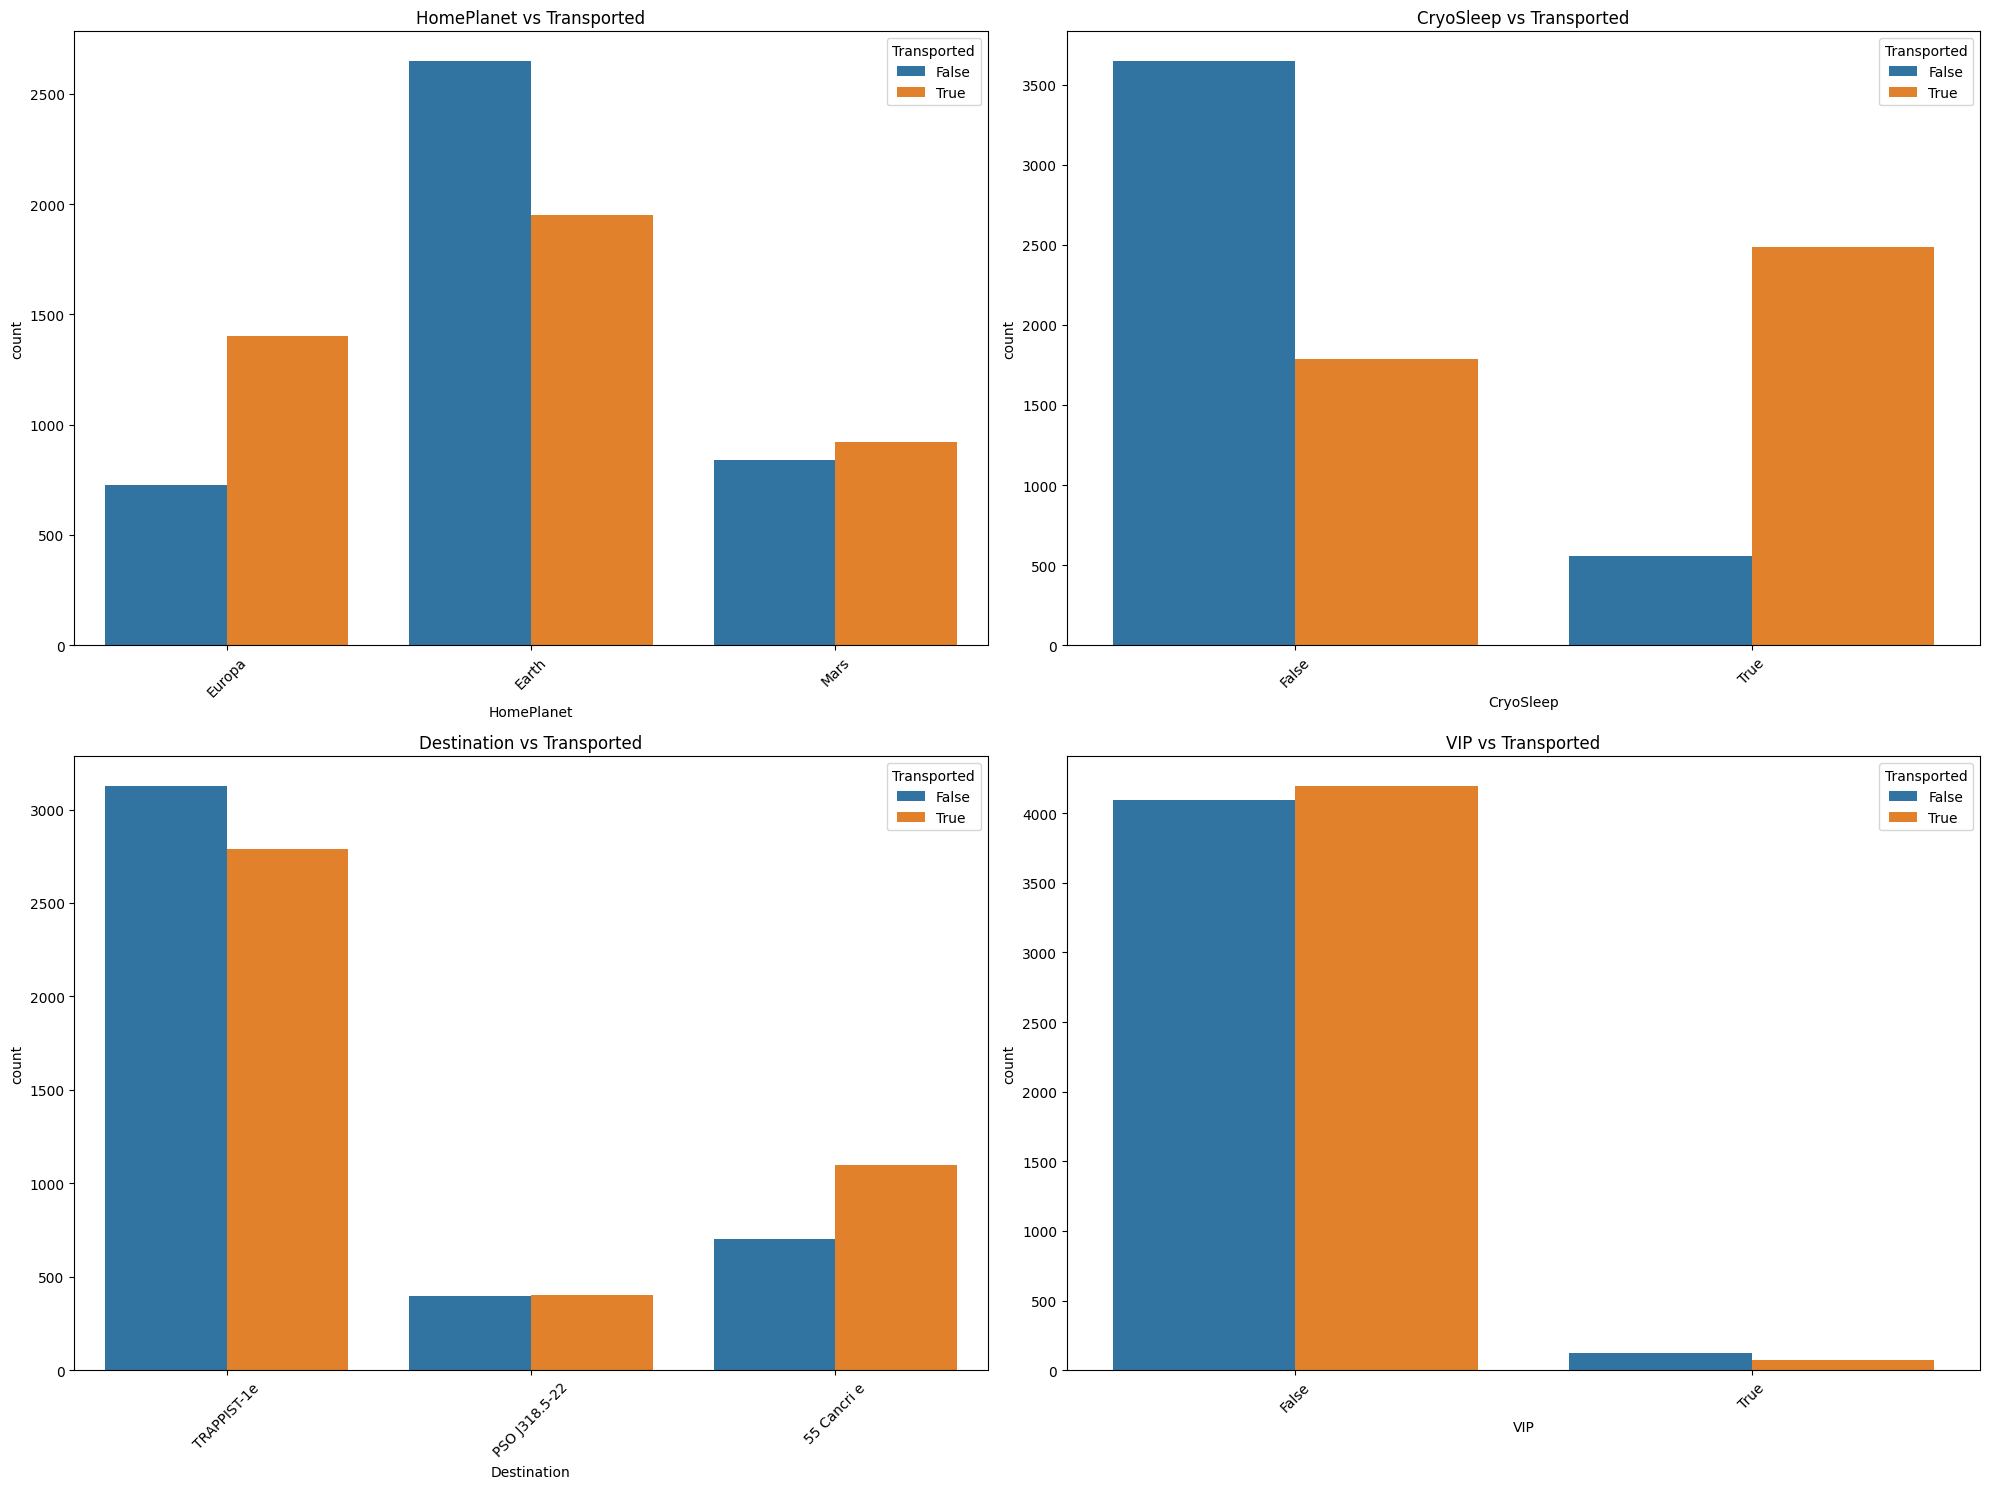

In [6]:
# Display data shape and info
print("Train data shape:", train_df.shape)
print("Test data shape:", test_df.shape)
print("Train data info:")
print(train_df.info())
print("Test data info:")
print(test_df.info())

# Statistical Information
print("Train data statistics:")
print(train_df.describe())
print("Test data statistics:")
print(test_df.describe())

# Statistical information of categorical data
print("Categorical data statistics (Train):")
print(train_df.describe(include=["O"]))
print("Categorical data statistics (Test):")
print(test_df.describe(include=["O"]))

# Data Visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 15))  # Adjust the number of subplots

def plot_transported(param, ax):
    sns.countplot(data=train_df, x=param, hue="Transported", ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_title(f"{param} vs Transported")

attributes = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

for i, attribute in enumerate(attributes):
    plot_transported(attribute, axes[i // 2, i % 2])

plt.tight_layout()
plt.show()


Step 4: Prepocessing: Pipeline-Check Missing Values, Drop unnecessary Columns and Encode the Categorical Columns

In [7]:
# Separate target from predictors
y = train_df['Transported']  # Target variable (what you want to predict)
X = train_df.drop('Transported', axis=1)  # Predictor variables (features)


# Split the training data into training and validation subsets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)


In [9]:
# Calculate cardinality for each categorical column
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']

cardinality = X_train[categorical_cols].nunique()

# Set a threshold (e.g., 10) for low cardinality
low_cardinality_cols = cardinality[cardinality < 10].index.tolist()

# Select columns with low cardinality for one-hot encoding
selected_categorical_cols = low_cardinality_cols

# Select numerical columns
numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]

# Define my_cols
my_cols = categorical_cols + numerical_cols

# Keep selected columns only
X_train = X_train[my_cols].copy()
X_val = X_val[my_cols].copy()


In [10]:
X_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
1554,1650_01,Earth,True,G/258/S,55 Cancri e,False,Walla Hodes,28.0,0.0,0.0,0.0,0.0,0.0
5941,6302_06,Earth,False,G/1015/P,55 Cancri e,False,Branca Simsey,12.0,0.0,0.0,0.0,0.0,NaN
4194,4473_02,Mars,False,E/292/S,TRAPPIST-1e,False,Terek Welte,27.0,994.0,0.0,26.0,1.0,0.0
7837,8366_03,Earth,True,G/1364/P,TRAPPIST-1e,False,Jodia Russon,2.0,0.0,0.0,0.0,0.0,0.0
1232,1308_01,Europa,True,NaN,55 Cancri e,False,Diram Plegred,40.0,0.0,0.0,0.0,0.0,0.0


In [25]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

# Define the columns by data type
numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in X_train.columns if X_train[cname].dtype == "object"]

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define the model (Random Forest in this case)
model = RandomForestClassifier()

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)])

# Fitting the Random Forest model to the training data
clf.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='constant'),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['PassengerId', 'HomePlanet',
                                                   'CryoSleep', 'Cabin',
                                                   'Destination', 'VIP',
                                                   'Name'])])),
                ('model', RandomForestClassifier())])

In [12]:
# Checking Missing Values
print("Missing values in Train data:")
print(train_df.isna().sum())
print("Missing values in Test data:")
print(test_df.isna().sum())

# Fill missing values
columns_to_fill = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
train_df[columns_to_fill] = train_df[columns_to_fill].fillna(0)
test_df[columns_to_fill] = test_df[columns_to_fill].fillna(0)

train_df['HomePlanet'] = train_df['HomePlanet'].fillna('Earth')
test_df['HomePlanet'] = test_df['HomePlanet'].fillna('Earth')

for planet in ['Earth', 'Europa', 'Mars']:
    train_df['Age'].fillna(train_df.loc[train_df['HomePlanet'] == planet]['Age'].median(), inplace=True)
    test_df['Age'].fillna(test_df.loc[test_df['HomePlanet'] == planet]['Age'].median(), inplace=True)
train_df['VIP'] = train_df['VIP'].fillna(False)
test_df['VIP'] = test_df['VIP'].fillna(False)

train_df['Destination'] = train_df['Destination'].fillna("TRAPPIST-1e")
test_df['Destination'] = test_df['Destination'].fillna("TRAPPIST-1e")

train_df['CryoSleep'] = train_df['CryoSleep'].fillna(False)
test_df['CryoSleep'] = test_df['CryoSleep'].fillna(False)

train_df['Cabin'] = train_df['Cabin'].fillna('G/734/S')
test_df['Cabin'] = test_df['Cabin'].fillna('G/734/S')



Missing values in Train data:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64
Missing values in Test data:
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


Step 5: Model Selection and Evaluation[using K-Fold Cross Validation]

Step 6: Model Training and Saving[using Joblib for saving model]

In [26]:
from sklearn.metrics import accuracy_score

# Making predictions on the validation set
y_pred_val = clf.predict(X_val)
accuracy_val = accuracy_score(y_val, y_pred_val)
print("Validation Accuracy:", accuracy_val)

# Fitting the model to the entire training data
clf.fit(X, y)

# Making predictions on the test data
y_pred_test = clf.predict(test_df)

# Save the trained model
joblib.dump(clf, 'spaceship_titanic_rf_model.pkl')



Validation Accuracy: 0.7796688132474701


['spaceship_titanic_rf_model.pkl']

Step 7: Model Predictions

In [27]:
# Making Predictions
submission = pd.DataFrame({'Transported': y_pred_test.astype(bool)}, index=test_df.index)

# Count the number of passengers transported safely and to an alternate dimension
transported_safe = len(submission[submission['Transported'] == False])
transported_dimension = len(submission[submission['Transported'] == True])

print(f"{transported_safe} people have been transported safely.")
print(f"{transported_dimension} people have been transported to an alternate dimension.")


2222 people have been transported safely.
2055 people have been transported to an alternate dimension.


In [28]:
# Extract the names of passengers who were transported to an alternate dimension
dimension_passengers = test_df[submission['Transported'] == True]['Name']

print("Passengers transported to an alternate dimension:")
print(dimension_passengers)


Passengers transported to an alternate dimension:
0        Nelly Carsoning
2        Sabih Unhearfus
3       Meratz Caltilter
6        Aldah Ainserfle
7         Acrabi Pringry
              ...       
4271         Danna Peter
4272         Jeron Peter
4274         Jayrin Pore
4275      Kitakan Conale
4276    Lilace Leonzaley
Name: Name, Length: 2055, dtype: object


In [29]:
# Extract the names of passengers who were not transported
safe_passengers = test_df[submission['Transported'] == False]['Name']

print("Passengers who were transported safely:")
print(safe_passengers)


Passengers who were transported safely:
1           Lerome Peckers
4          Brence Harperez
5             Karlen Ricks
9        Eliana Delazarson
10           Vivia Rickson
               ...        
4261         Glendy Reenon
4263     Eriana Jenkinnedy
4264         Hilip Lambles
4268    Sonald Hurchrisong
4273         Matty Scheron
Name: Name, Length: 2222, dtype: object


In [30]:
# Save the predictions to a CSV file
submission.to_csv('transportation_predictions.csv')
